In [1]:
import tensorflow as tf

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re
import datetime

In [2]:
images_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/PNG")
masks_paths = os.listdir("/Users/esmasert/Desktop/Maskeler/TRAINING/ISKEMI/MASK/")

In [3]:
len(images_paths), len(masks_paths)

(1130, 1130)

In [4]:
val_size = int(len(images_paths) * .20)
val_size

226

In [5]:
X_train = images_paths[val_size:]
X_val = images_paths[:val_size]

In [6]:
len(X_train), len(X_val)

(904, 226)

# Generator

In [7]:
class DataGenerator(Sequence):
    
    def __init__(self, images_paths, batch_size=32, validation=False, predict=False, shuffle=True):
        
        self.batch_size = batch_size
        self.images_paths = images_paths
        self.shuffle = shuffle
        self.validation = validation
        self.predict = predict
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images_paths) / self.batch_size))

    def __getitem__(self, index):
        
        from_range = index * self.batch_size
        to_range = (index + 1) * self.batch_size
        indexes = self.indexes[from_range:to_range]
      
        if self.predict:
            X = self.__load_predict__(indexes)
            return X
      
        else:
            X, y = self.__load__(indexes)
            return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images_paths))
      
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __load_image__(self, index):
        
        image_path = self.images_paths[index]
  
        image_loaded = image.load_img(f'/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/PNG/{image_path}')
        image_loaded = image.img_to_array(image_loaded)
        image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
      
        image_loaded = image_loaded / 255.0
      
        return image_loaded
    
    def __load_image_and_mask__(self, index):
        
        image_path = self.images_paths[index]
        mask_path = image_path[:-4] + ".png"
  
        image_loaded = image.load_img(f'/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/PNG/{image_path}')
        image_loaded = image.img_to_array(image_loaded)
        image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)

        mask_loaded = image.img_to_array(image.load_img(f'/Users/esmasert/Desktop/Maskeler/TRAINING/ISKEMI/MASK/{mask_path}', color_mode="grayscale"))
        mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)
      
        image_loaded = image_loaded / 255.0
        mask_loaded = mask_loaded / 255.0
      
        return image_loaded, mask_loaded
    
    def __load_predict__(self, indexes):
        X = []
      
        for index in indexes:
            img = self.__load_image__(index)
            X.append(img)

        return np.array(X)
    
    def __load__(self, indexes):
        X = []
        y = []
      
        for index in indexes:
            img, mask = self.__load_image_and_mask__(index)
            X.append(img)
            y.append(mask)
      
        return np.array(X), np.array(y)

# Network

In [8]:
def downstream_block(layer, number_filters):
    
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)
  
    return layer, cropped_feature_map

In [9]:
def upstream_block(layer, number_filters, cropped_feature_map):
    
    layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
    layer = layers.concatenate([layer, cropped_feature_map])
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  
    return layer

In [10]:
def u_net():
    
    input = layers.Input(input_shape)
    layer = input
  
    cropped_feature_maps = []
  
    for index in range(steps + 1):
        current_number_filters = number_filters * 2 ** index
        layer, cropped_feature_map = downstream_block(layer, current_number_filters)
        cropped_feature_maps.append(cropped_feature_map)
  
    layer = cropped_feature_maps.pop()
  
    for index in range(steps - 1, -1, -1):
        current_number_filters = number_filters * 2 ** index
        layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])
  
    output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
    model = Model(input, output)
  
    return model

In [11]:
input_shape = (512, 512, 3)
img_size = 512
number_filters = 16 
steps = 4
number_classes = 1

In [12]:
model = None
model = u_net()

In [13]:
batch_size = 32

learning_rate = 3e-4
epochs = 50

In [14]:
def polynomial_decay(epoch):
    power = 1.0
    
    alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
    return alpha

In [15]:
#weights_name = "epoch={epoch:02d}|accuracy={acc:.4f}|val_acc={val_acc:.4f}.h5"
#filepath="weights/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

#checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True,
#                                 save_weights_only=True, mode="max", save_freq=1)


filepath="/Users/esmasert/Desktop/models/10epoch.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', save_freq=1)


lr_decay = LearningRateScheduler(polynomial_decay)

In [16]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['acc'])

In [17]:
train_steps = int(len(X_train) / batch_size)
val_steps = int(len(X_val) / batch_size)

In [18]:
train_steps, val_steps

(28, 7)

In [19]:
train_generator = DataGenerator(X_train, batch_size)
val_generator = DataGenerator(X_val, batch_size, validation=True)

In [20]:
log_dir = "/Users/esmasert/Desktop/segmentationLogs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [21]:
# train the network
trained_model = model.fit_generator(train_generator, epochs=10, validation_data=val_generator, steps_per_epoch=3, callbacks=[tensorboard_callback])

/Users/esmasert/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3/3 [==============================] - 262s 99s/step - loss: 0.6872 - acc: 0.7515 - val_loss: 0.6706 - val_acc: 0.9792
Epoch 2/10
3/3 [==============================] - 242s 91s/step - loss: 0.6536 - acc: 0.9766 - val_loss: 0.6005 - val_acc: 0.9795
Epoch 3/10
3/3 [==============================] - 241s 91s/step - loss: 0.4956 - acc: 0.9773 - val_loss: 0.1297 - val_acc: 0.9792
Epoch 4/10
3/3 [==============================] - 240s 91s/step - loss: 0.0767 - acc: 0.9806 - val_loss: 0.1845 - val_acc: 0.9792
Epoch 5/10
3/3 [==============================] - 234s 90s/step - loss: 0.1005 - acc: 0.9839 - val_loss: 0.0272 - val_acc: 0.9792
Epoch 6/10
3/3 [==============================] - 237s 92s/step - loss: 0.0162 - acc: 0.9814 - val_loss: 0.0118 - val_acc: 0.9792
Epoch 7/10
3/3 [==============================] - 234s 90s/step - loss: 0.0161 - acc: 0.9799 - val_loss: 0.0176 - val_acc: 0.9794
Epoch 8/10
3/3 [==============================] - 235s 90s/step - loss: 0.0129 - acc: 0.97

In [22]:
def print_image_and_masks(X, index):
    
    image_path = X[index]
    print(image_path)

    mask_path = image_path[:-4] + ".png"

    image_loaded = image.load_img(f'/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/PNG/{image_path}')
    image_loaded = image.img_to_array(image_loaded)
    image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
  
    mask_loaded = image.img_to_array(image.load_img(f'/Users/esmasert/Desktop/Maskeler/TRAINING/ISKEMI/MASK/{mask_path}', color_mode="grayscale"))
    mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)

    image_loaded = image_loaded / 512.0
    mask_loaded = mask_loaded / 512.0
  
    image_array = np.expand_dims(image_loaded, axis=0)
  
    predictions = model.predict(image_array)
  
    mask_predicted = predictions[0]

    has_mask = mask_loaded.max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image_loaded)

    if has_mask:
        ax[0].contour(mask_loaded.reshape(512, 512), colors='k', levels=[0.5])
    ax[0].set_title('Original image')

    ax[1].imshow(mask_loaded.reshape(512, 512))
    ax[1].set_title('True Mask')

    ax[2].imshow(mask_predicted.reshape(512, 512), vmin=0, vmax=1)

    if has_mask:
        ax[2].contour(mask_loaded.reshape(512, 512), colors='yellow', levels=[0])
    ax[2].set_title('Predicted Mask')

11364.png


<ipython-input-22-0cd1381d254b>:30: UserWarning: No contour levels were found within the data range.
  ax[0].contour(mask_loaded.reshape(512, 512), colors='k', levels=[0.5])
<ipython-input-22-0cd1381d254b>:39: UserWarning: No contour levels were found within the data range.
  ax[2].contour(mask_loaded.reshape(512, 512), colors='yellow', levels=[0])


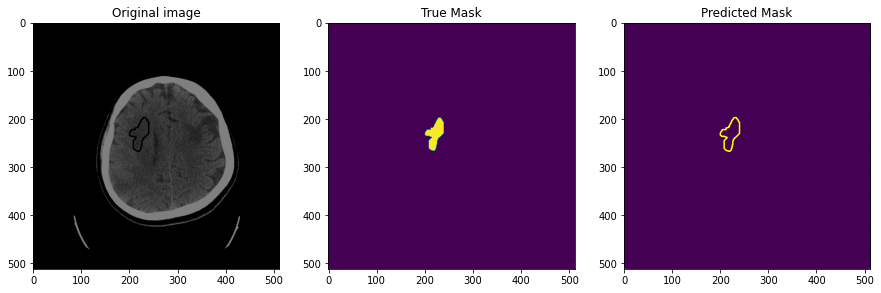

In [23]:
print_image_and_masks(X_train, 0)

15895.png


<ipython-input-22-0cd1381d254b>:30: UserWarning: No contour levels were found within the data range.
  ax[0].contour(mask_loaded.reshape(512, 512), colors='k', levels=[0.5])
<ipython-input-22-0cd1381d254b>:39: UserWarning: No contour levels were found within the data range.
  ax[2].contour(mask_loaded.reshape(512, 512), colors='yellow', levels=[0])


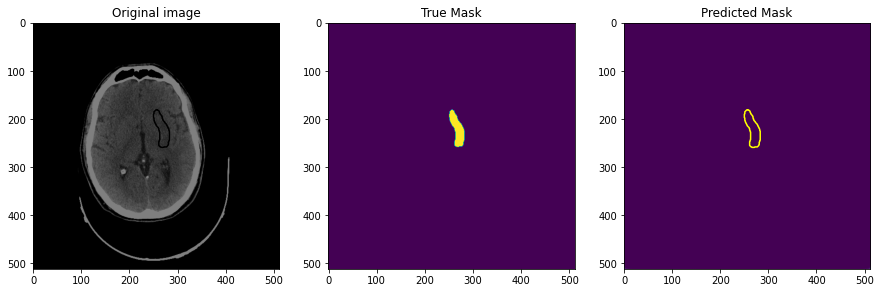

In [24]:
print_image_and_masks(X_train, 9)

11118.png


<ipython-input-22-0cd1381d254b>:30: UserWarning: No contour levels were found within the data range.
  ax[0].contour(mask_loaded.reshape(512, 512), colors='k', levels=[0.5])
<ipython-input-22-0cd1381d254b>:39: UserWarning: No contour levels were found within the data range.
  ax[2].contour(mask_loaded.reshape(512, 512), colors='yellow', levels=[0])


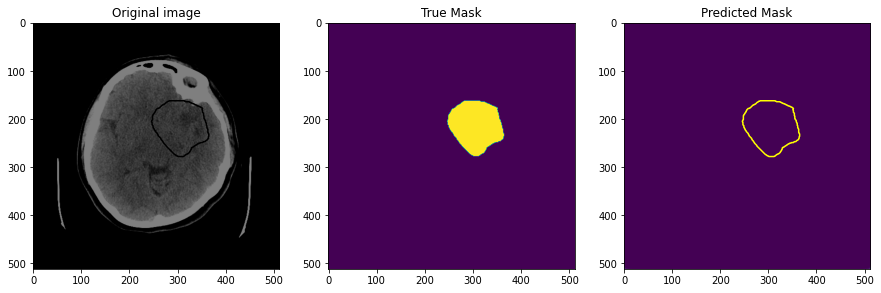

In [25]:
print_image_and_masks(X_train, 559)

14812.png


<ipython-input-22-0cd1381d254b>:30: UserWarning: No contour levels were found within the data range.
  ax[0].contour(mask_loaded.reshape(512, 512), colors='k', levels=[0.5])
<ipython-input-22-0cd1381d254b>:39: UserWarning: No contour levels were found within the data range.
  ax[2].contour(mask_loaded.reshape(512, 512), colors='yellow', levels=[0])


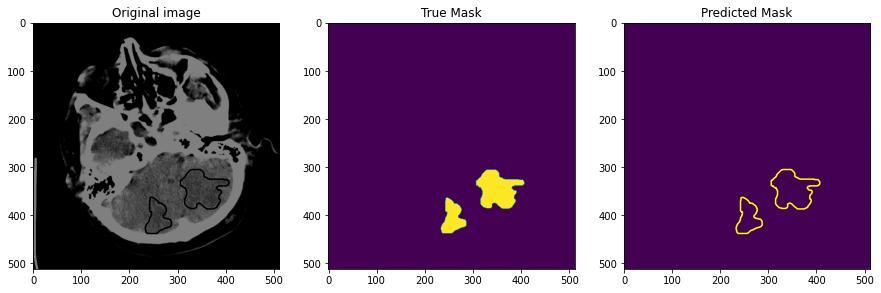

In [26]:
print_image_and_masks(X_val, 7)

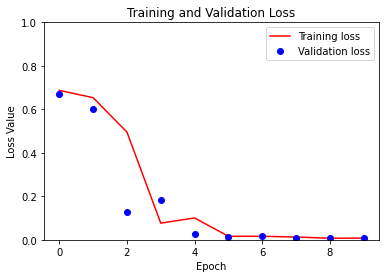

In [27]:
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.figure()
plt.plot(trained_model.epoch, loss, 'r', label='Training loss')
plt.plot(trained_model.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [28]:
# %tensorboard --logdir /Users/esmasert/Desktop/segmentationLogs/

In [29]:
history = trained_model

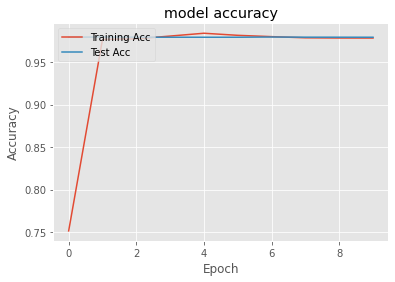

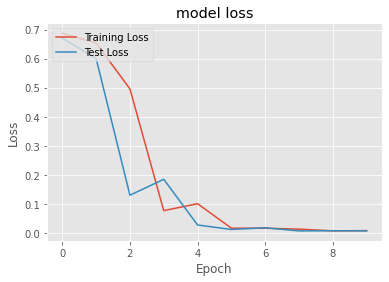

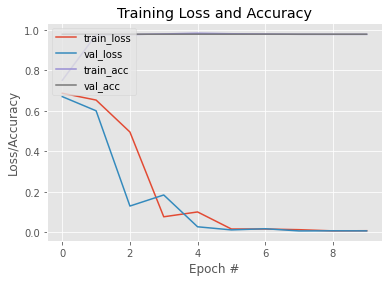

In [42]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = 10
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [43]:
score = model.evaluate_generator(val_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

/Users/esmasert/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation Score:  0.00701650558039546
Validation Accuracy:  0.9791674017906189
